In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#same as in task 2
# load datasets
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")
products_df = pd.read_csv("Products.csv")

# merge datasets
transactions_df = transactions_df.merge(products_df, on="ProductID")
merged_df = transactions_df.merge(customers_df, on="CustomerID")

# view the merged data
print(merged_df.head())


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x                      ProductName     Category  Price_y  \
0      300.68   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
1      300.68   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
2      300.68   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
3      601.36   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
4      902.04   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   

      CustomerName         Region  SignupDate  
0   Andrea Jenkins         Europe  202

In [ ]:
#same as in task 2


# Summarize transaction data per customer
transaction_summary = merged_df.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean'],       # Total and average spending
    'TransactionID': 'count',           # Number of transactions
    'Category': lambda x: x.mode()[0]   # Most purchased category
}).reset_index()

# Flatten multi-level column names
transaction_summary.columns = ['CustomerID', 'TotalSpending', 'AvgSpending', 'TransactionCount', 'FavCategory']

# Merge with customer profiles
customer_profiles = customers_df.merge(transaction_summary, on='CustomerID')

# One-hot encode categorical features (Region and FavCategory)
encoder = OneHotEncoder(sparse_output=False)
encoded_region = encoder.fit_transform(customer_profiles[['Region']])
encoded_category = encoder.fit_transform(customer_profiles[['FavCategory']])

print(customer_profiles.columns)

features = np.hstack([
    encoded_region,
    encoded_category,
    customer_profiles[['TotalSpending', 'AvgSpending', 'TransactionCount']].values
])



# Standardize features using standard scaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)



Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate', 'TotalSpending',
       'AvgSpending', 'TransactionCount', 'FavCategory'],
      dtype='object')


In [ ]:
#clustering
# choose the number of clusters
num_clusters = 5  #(By default taking 5 cluster)

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(features_scaled)

# Add cluster labels to the customer profiles
customer_profiles['Cluster'] = labels

# Calculate DB Index
db_index = davies_bouldin_score(features_scaled, labels)
print(f"DB score: {db_index}")

# Calculate  for additional evaluation
silhouette_avg = silhouette_score(features_scaled, labels)
print(f"Silhouette Score: {silhouette_avg}")


DB score: 1.6875192966826156
Silhouette Score: 0.21619276557734993


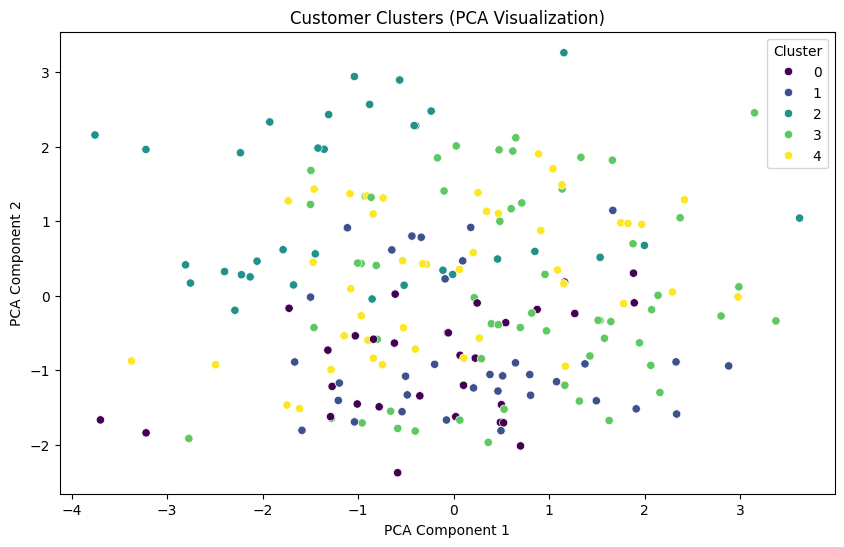

<Figure size 640x480 with 0 Axes>

In [ ]:
# reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_scaled)

# a0dd PCA components and cluster labels for visualization
visual_df = pd.DataFrame(features_2d, columns=['PCA1', 'PCA2'])
visual_df['Cluster'] = labels

# plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visual_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title('Customer Clusters (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()
plt.savefig('customer_clusters.png')